# Supervised Anomaly Detection and Unbalanced Data

The topic we'll look at over the next couple of tutorials is [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection). This is probably the most common and important application of machine learning tools to security. We'll start this week with supervised anomaly detection, and continue next week with unsupervised anomaly detection. There are a huge number of anomaly detection techniques out there, and many of them are very specialized to particular types of data, so all we'll be able to do here is scratch the surface.

As the name suggests, you can think of an _anomaly_ as some sort of highly unusual event occuring in your data that you wish to find (e.g. an attack on your network, a defective device, credit card fraud). More usefully, a good definition of an anomaly is the following: An anomaly is a data sample that deviates significantly from other data samples, so much so to suggest that it was generated by a different mechanism. In probability language, you can think of an anomaly as something that comes from a different distribution than the "real" data.

If we happen to know which points in the dataset we're training on are anomalies, we can use supervised learning techniques (specifically binary classification) to build an anomaly detection model. By convention, people usually use the label `0`, called _negative samples_ , for non-anomalous samples, and `1` for anomalies, called _positive samples_ .

Supervised anomaly detection happens to be a special case of the more general problem of _unbalanced data_ . That is, the number of labels you have for each class is significantly different. Till now we've worked with _balanced data_ , which assumes the number of labels for each class is roughly equal (e.g. with 100 samples, you'd have 50 with negative labels and 50 with positive labels, or close to that ratio). With unbalanced data they can be highly skewed (e.g. with 100 samples, you might have 98 with negative labels and 2 with positive labels).

In the examples below we talk about various ways to deal with unbalanced data for a binary classification problem like supervised anomaly detection. Many of the techniques work just as well for multiclass problems (e.g. image classification). We begin by loading in the packages we'll use. The new one we'll use here is the [imbalanced-learn](http://imbalanced-learn.org/) library, aka `imblearn`. This library has many techniques for dealing with unbalanced data that we'll use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.datasets import make_imbalance
np.random.seed(123)

The dataset we'll be working with is a spam classification dataset. The `0` labels are non-spam and the `1` labels are spam. The dataset contains 57 derived features (using NLP). To make the dataset unbalanced we specify that only 2% of the dataset should be positive samples.

In [2]:
def get_data(ratio=0.01,get_all=False):
    # loads spam dataset, where only (ratio*100)% of data is spam (1), else non-spam (0)
    df = pd.read_csv("http://www.apps.stat.vt.edu/leman/VTCourses/spam.data.txt",sep=' ')
    X_all = df.iloc[:,:-1]
    y_all = df.iloc[:,-1]
    if get_all:
        return X_all,y_all
    X,y = make_imbalance(X_all, y_all, 
                         sampling_strategy={1: min(round(len(y_all)*ratio),len(y_all[y_all==1]))}, 
                         random_state=42)
    X = StandardScaler().fit_transform(X)
    return X,y

X,y = get_data(ratio=0.02)
print('number of features: ',len(X.T))
print('number of total samples: ',len(y))
print('number of negative samples: ',len(y[y==0]))
print('number of positive samples: ',len(y[y==1]))
print('percent positive samples: %.2f%%' % float(len(y[y==1])/(len(y[y==0])+len(y[y==1]))*100))
print('percent negative samples: %.2f%%' % float(len(y[y==0])/(len(y[y==0])+len(y[y==1]))*100))

number of features:  57
number of total samples:  2880
number of negative samples:  2788
number of positive samples:  92
percent positive samples: 3.19%
percent negative samples: 96.81%


Here's a 2D t-SNE plot of the dataset so you can see what the situation looks like.

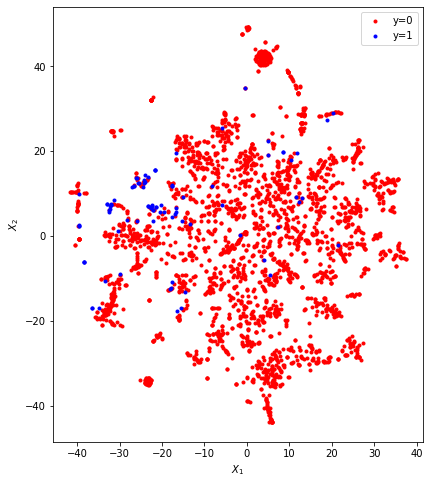

In [3]:
def plot_model(model, X, y):
    xlim_left = np.min(X[:,0])
    xlim_right = np.max(X[:,0])
    ylim_left = np.min(X[:,1])
    ylim_right = np.max(X[:,1])
    xx, yy = np.mgrid[xlim_left-1:xlim_right+1:.1, ylim_left-1:ylim_right+1:.1]
    grid = np.c_[xx.ravel(), yy.ravel()]    
    f, ax = plt.subplots(figsize=(8, 8))    
    if model is not None:
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contour(xx, yy, yhat, levels=[.5])
    x1 = X[y==0]
    x2 = X[y==1]
    ax.scatter(x1[:,0],x1[:,1],marker='.',c='red',label='y=0')
    ax.scatter(x2[:,0],x2[:,1],marker='.',c='blue',label='y=1')
    ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
    ax.legend(loc='upper right')

tsne = TSNE(n_components=2, n_jobs=-1)
X_tsne = tsne.fit_transform(X)
plot_model(None, X_tsne, y)

So why can't we just do classification as usual at this point? There are several problems with doing this. For one, accuracy becomes a bad way to measure model performance with unbalanced data. To see this, consider the following scenario. What happens if we build a "stupid" classifier that just classifies all points as `0`?

To address the accuracy problem we instead must use a different metric to measure model performance. But which one? To understand the various metrics we've got to talk about the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The confusion matrix contains 4 numbers that we ultimately care about:

1. True positives (TP): Number of `1` the model correctly predicted were `1`.
2. False positives (FP): Number of `0` the model incorrectly predicted were `1`.
3. True negatives (TN): Number of `0` the model correctly predicted were `0`.
4. False negatives (FN): Number of `1` the model incorrectly predicted were `0`.

In sklearn, these 4 numbers are stored in the following way (note the diagonals are swapped from how you'd see them in a typical statistics textbook!):

$$ \text{confusion matrix = }
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
$$

Just about every metric we'd use to measure model performance of a binary classifier is contained in these 4 numbers. Specifically, we'll focus mainly on the following 4 metrics:

1. Accuracy: $\frac{TP+TN}{TP+TN+FP+FN}$
2. Precision: $\frac{TP}{TP+FP}$
3. Recall: $\frac{TP}{TP+FN}$
4. $F_1$: $\frac{precision \cdot recall}{precision + recall}$

There is also another important metric people use called the [area under the receiver operating curve]((https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)), aka AUC or AUROC. I won't go into details on this one, but look it up if you're interested.

With all of these metrics, you can think of values closer to 0 as "bad" and values closer to 1 as good. Below shows what all these scores are for the "all zero" case mentioned above.

In [4]:
def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y,yhat),4))
    print('precision: ', round(precision_score(y,yhat),4))
    print('recall: ', round(recall_score(y,yhat),4))
    print('f1: ', round(f1_score(y,yhat),4))
    print('auc: ', round(roc_auc_score(y,yhat),4))
    print('confusion matrix:\n', confusion_matrix(y,yhat))

In [5]:
# using since precision and F1 are technically undefined in this case (why?)
import warnings; warnings.filterwarnings('ignore')

yhat = np.zeros(y.shape)
get_scores(y,yhat)

accuracy:  0.9681
precision:  0.0
recall:  0.0
f1:  0.0
auc:  0.5
confusion matrix:
 [[2788    0]
 [  92    0]]


You can see that accuracy isn't a useful metric at all when dealing with unbalanced data, because it mostly just reflects how unbalanced the data is. To avoid this it's better to focus on one of the other metrics. The $F_1$ score is probably the most commonly used for this. In the above scenario, $F_1$ correctly tells us that our model is terrible because it can't pick out the positive labels from the negative ones.

Now let's get to training models on unbalanced data. Recall the first thing you need to do is split your dataset into a training set and a test set. When dealing with unbalanced data, it's important that your test set correctly reflect the ratio of positives and negatives in your dataset, so we split the test set off before doing anything special with the data, and leave the test set alone (this is important or your metrics won't truly reflect how well your models is doing!). We again choose to take about 20% of the data for the test set (which is reasonable when you have a few thousand data samples or less).

**Important Note:** When you have extreme data imbalance, if you're not careful, you could end up in a situation where you have no positive samples in your test set. You want to avoid this. Your test set needs to contain at least a handful of positive samples to tell you how well you're doing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We can start by just trying to train a model on the data we have without doing any kind of sampling. Sometimes this will work if the dataset isn't too imbalanced. However for extreme imbalance (like when your minority class is 1% of your data, some kind of resampling is almost always a good strategy. 

We see that here. Notice that in this naive training case that all our test set metrics are zero. Why? Because the model didn't see enough positive examples in the training set to learn to differentiate them, hence everything gets classified as `0`. Resampling can help with this problem and improve performance.

In [7]:
model = RandomForestClassifier(min_samples_leaf=20, random_state=5, n_jobs=-1)
model.fit(X_train, y_train)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9688
precision:  0.0
recall:  0.0
f1:  0.0
auc:  0.5
confusion matrix:
 [[558   0]
 [ 18   0]]


We could just start training now the same way we did before with balanced data, but that's not a good idea. ML works best when you **train on balanced data** but **test on the true unbalanced data**. There are different ways of balancing the training set, but they pretty much all fall under two categories:

1. Undersampling: Throw out enough negative samples to make the training set balanced.
2. Oversampling: Keep adding in positive samples to make the training set balanced.

We can do each of these easily in Python using the imblearn package mentioned above. We'll start by looking at a few undersampling techniques, and then finish with a few oversampling techniques. Since we'll want to focus on how sampling affects training in this notebook, we'll just pick a model and stick with it for each sampling case. Since we mentioned before that Random Forests are easy to use and often work very well, we'll use those. In practice though you'll want to experiment with different models and hyperparameter choices for each sampling case.

We start with naive undersampling, aka random undersampling. All random undersampling does is takes your training set and randomly throws away enough of negative samples to make the training set balanced. As a result, the new, balanced training set will be _much_ smaller than the original one.

In [8]:
X_train_bal, y_train_bal = RandomUnderSampler(random_state=543).fit_sample(X_train, y_train)
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal==1]))

original training set size:  2304
new training set size:  148
number of negative samples:  74
number of positive samples:  74


In [9]:
model = RandomForestClassifier(min_samples_leaf=20, random_state=5, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9635
precision:  0.44
recall:  0.6111
f1:  0.5116
auc:  0.793
confusion matrix:
 [[544  14]
 [  7  11]]


Ignoring accuracy (which is obviously biased), you can see we're doing poorly wrt to precision, which is causing $F_1$ to be low as well. This means that our model isn't "picky" enough when classifying points as a `1`. One huge reason for this is that we're not training on that much data, only 148 samples. That's because we're undersampling.

Another undersampling technique people use involves clustering the negative samples and only keeping those cluster centers as points in the new training set. Suppose you have $n$ positive samples and $N$ negative samples with $n \ll N$. Then [cluster-based undersampling](http://imbalanced-learn.org/en/stable/auto_examples/under-sampling/plot_cluster_centroids.html#sphx-glr-auto-examples-under-sampling-plot-cluster-centroids-py) works by doing k-means on the $N$ negative samples only with $k=n$. It then throws out the $N$ negative samples and replaces them with the $n$ centers calculated from the clustering.

In [10]:
X_train_bal,y_train_bal = ClusterCentroids(random_state=543).fit_sample(X_train, y_train)
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal==1]))

original training set size:  2304
new training set size:  148
number of negative samples:  74
number of positive samples:  74


In [11]:
model = RandomForestClassifier(min_samples_leaf=7, random_state=5, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.7882
precision:  0.1119
recall:  0.8333
f1:  0.1974
auc:  0.81
confusion matrix:
 [[439 119]
 [  3  15]]


It looks like cluster-based undersampling does worse (at least with random forests). Precision is still pretty bad. Again, this is mainly because we're not using much data due to undersampling. 

To make sure we're using all of our data we can use oversampling techniques instead. Note the drawback to oversampling is that it's very easy to overfit the positive samples if you're not careful. We'll first look at naive oversampling, aka random oversampling. All this does is randomly copies positive samples in the training set until the training set balances.

In [12]:
X_train_bal,y_train_bal = RandomOverSampler(random_state=543).fit_sample(X_train, y_train)
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal==1]))

original training set size:  2304
new training set size:  4460
number of negative samples:  2230
number of positive samples:  2230


In [13]:
model = RandomForestClassifier(min_samples_leaf=5, random_state=5, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9774
precision:  0.6316
recall:  0.6667
f1:  0.6486
auc:  0.8271
confusion matrix:
 [[551   7]
 [  6  12]]


You can see that oversampling does much better than undersampling, which fits the general principle that "machine learning models perform better with more data". Another oversampling technique is [SMOTE](http://imbalanced-learn.org/en/stable/over_sampling.html#smote-adasyn). Instead of just copying positive samples to balance the dataset, SMOTE uses nearest neighbor interpolation to generate more positive samples. This insures new positive samples added to the training set aren't exactly like the originals, but "close enough" to look like them. This should help with overfitting worries.

In [14]:
X_train_bal, y_train_bal = SMOTE(random_state=543).fit_sample(X_train, y_train)
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal==1]))

original training set size:  2304
new training set size:  4460
number of negative samples:  2230
number of positive samples:  2230


In [15]:
model = RandomForestClassifier(min_samples_leaf=5, random_state=5, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9809
precision:  0.7059
recall:  0.6667
f1:  0.6857
auc:  0.8289
confusion matrix:
 [[553   5]
 [  6  12]]


The last oversampling technique we mention is ADASYN. ADASYN works similarly to SMOTE, but differs slightly in how it generates the new positive samples. With minimal tuning, it looks like ADASYN is performing the best for us in our particular case.

In [16]:
X_train_bal, y_train_bal = ADASYN(random_state=543).fit_sample(X_train, y_train)
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal==1]))

original training set size:  2304
new training set size:  4458
number of negative samples:  2230
number of positive samples:  2228


In [17]:
model = RandomForestClassifier(min_samples_leaf=5, random_state=5, n_jobs=-1)
model.fit(X_train_bal, y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9844
precision:  0.7647
recall:  0.7222
f1:  0.7429
auc:  0.8575
confusion matrix:
 [[554   4]
 [  5  13]]


**Final Aside:** Since I generated this spam dataset originally from a balanced dataset, it's natural to ask how well we could've done if we had more positive samples to begin with. Here you go. 

**Moral**: It's almost impossible to beat having real balanced data to begin with. If you can collect more positive samples to balance the dataset, do. Nothing beats real data.

In [18]:
X_all,y_all = get_data(get_all=True)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)

model = RandomForestClassifier(min_samples_leaf=5, random_state=5, n_jobs=-1)
model.fit(X_train, y_train)

yhat = model.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9315
precision:  0.946
recall:  0.8663
f1:  0.9044
auc:  0.9184
confusion matrix:
 [[559  17]
 [ 46 298]]
